# Beating SP500 with a Global CAPE Switching Strategy

### What is the CAPE ratio
The CAPE ratio is a valuation measure that uses real earnings per share (EPS) over a 10-year period. Unlike the traditional TTM PE ratio, the CAPE ratio covers a timespan that includes multiple stages of the bussiness cycle, making it a better indicator of future returns. 

For this exploration, we will be focusing on the CAPE ratio as it is applied to a market-cap weighted index of multiple global stock markets. 

### Background
Multiple studies and historical analysis point towards the effectiveness of the CAPE ratios in predicting future stock market returns. 

In a paper by [Star Capital](https://www.starcapital.de/fileadmin/user_upload/files/publikationen/Research_2016-01_Predicting_Stock_Market_Returns_Shiller_CAPE_Keimling.pdf), they show that an inverse correlation exists between the CAPE ratio and the future 10-15 year returns using data that goes back to 1979 for the world markets and 1881 for the US stock market. 

In this [blog post](https://mebfaber.com/2019/01/06/you-would-have-missed-961-in-gains-using-the-cape-ratio-and-thats-a-good-thing/), Meb Faber takes it a step further and shows how a CAPE switching strategy would have performed between 1993 and 2018 against other sp500 and bond buy-and-hold strategies. 

Both studies omit the inclusion of the data that was used for the analysis or the code that was used to generate their results. This makes it hard to replicate and analyze their methodology.

### Datasets
- Historcal CAPE ratios for different countries going all the way back up to 1982. Data compiled and calculated by Barclays. Contains a total of 25 countries. Monthly granularity.

- Stock market return of MSCI indices for each of the 25 countries. Data is gross returns (dividends reinvested, not adjusted for inflation). Returns measured in USD, not local currencies.

- Yearly returns for a wide array of assets compiled by backtestportfolio. USD inflation rates, US bond returns, and Global bond returns going all the way back to 1972 are extracted from here.

- Lack country market caps/country weights. 


### Methodology
We will be testing out multiple strategies involving CAPE ratios, including picking lowest n countries by CAPE ratio, applying a maximun CAPE ratio limit, and weighting countries by CAPE ratio. Weights will be resampled on an annual basis.



In [59]:
import os
import pandas as pd
import numpy as np
import functools
import helper
import pprint
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter()

### Data Ingestion

In [3]:
yearly_cape = helper.ingest_cape_data()
asset_returns = helper.ingest_asset_returns()
year_percentage_returns = helper.compute_yearly_percentage(asset_returns['Bonds'])

In [3]:
yearly_cape.head()

,Australia,Brazil,Canada,China,France,Germany,Hong Kong,India,Israel,Italy,...,Russia,Singapore,South Africa,Spain,Sweden,Switzerland,Taiwan,Turkey,United Kingdom,USA
Date,,,,,,,,,,,,,,,,,,,,,
1981,12.39,NaN,10.71,NaN,NaN,9.63,31.22,NaN,NaN,NaN,...,NaN,33.70,NaN,NaN,11.14,9.20,NaN,NaN,8.84,9.35
1982,11.14,NaN,9.70,NaN,NaN,9.76,31.91,NaN,NaN,NaN,...,NaN,33.20,NaN,NaN,11.09,9.06,NaN,NaN,9.28,9.20
1983,10.73,NaN,10.86,NaN,NaN,10.35,16.23,NaN,NaN,NaN,...,NaN,28.38,NaN,NaN,18.29,10.59,NaN,NaN,10.72,11.06
1984,14.50,NaN,13.28,NaN,NaN,14.61,17.13,NaN,NaN,NaN,...,NaN,33.73,NaN,NaN,24.15,13.59,NaN,NaN,13.29,12.12
1985,14.36,NaN,14.62,NaN,NaN,15.43,19.08,NaN,NaN,NaN,...,NaN,24.20,NaN,NaN,17.33,14.92,NaN,NaN,15.81,12.93


In [4]:
year_percentage_returns.tail()

,Italy,Turkey,Spain,United Kingdom,France,Switzerland,Mexico,Japan,Korea,Canada,...,Germany,Hong Kong,Brazil,Netherlands,Russia,Singapore,Sweden,Taiwan,Poland,Bonds
Date,,,,,,,,,,,,,,,,,,,,,
2015,0.890115,0.700536,0.833762,0.877996,0.955021,0.929699,0.881526,0.985574,0.863654,0.812622,...,0.883588,0.854795,0.582567,0.987443,1.049303,0.765066,0.865465,0.840814,0.724770,0.9643
2016,1.020897,0.937268,1.109197,1.077497,1.117379,1.079111,0.962839,1.160987,1.246519,1.335019,...,1.170946,1.214612,1.992350,1.101698,1.568411,1.208214,1.169760,1.315511,1.196857,1.0425
2017,1.484545,1.408702,1.353866,1.244939,1.381839,1.239331,1.227003,1.254246,1.422823,1.137432,...,1.319909,1.322867,1.313370,1.387702,1.197782,1.331987,1.222776,1.317461,1.529216,1.0921
2018,0.807605,0.662667,0.824848,0.892725,0.871487,0.934722,0.862155,0.886912,0.846142,0.934603,...,0.789353,0.949107,1.006389,0.879993,1.014205,0.900943,0.871051,0.868223,0.847375,0.9618
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0238


In [5]:
asset_returns.tail()

,Inflation,US Stock Market,US Large Cap,US Large Cap Value,US Large Cap Growth,US Mid Cap,US Mid Cap Value,US Mid Cap Growth,US Small Cap,US Small Cap Value,...,Long-Term Corporate Bonds,High Yield Corporate Bonds,Short-Term Tax-Exempt,Intermediate-Term Tax-Exempt,Long-Term Tax-Exempt,REIT,Gold,Precious Metals,Commodities,Bonds
Year,,,,,,,,,,,,,,,,,,,,,
2015,0.0073,0.0029,0.0125,-0.0104,0.0317,-0.0145,-0.0191,-0.0113,-0.0378,-0.0477,...,-0.0220,-0.0140,0.0045,0.0285,0.0397,0.0222,-0.1067,-0.2942,-0.3406,0.9643
2016,0.0207,0.1253,0.1182,0.1675,0.0599,0.1107,0.1511,0.0662,0.1817,0.2465,...,0.0783,0.1119,0.0036,0.0008,0.0062,0.0834,0.0803,0.5064,0.1012,1.0425
2017,0.0211,0.2105,0.2167,0.1699,0.2765,0.1912,0.1691,0.2172,0.1610,0.1167,...,0.1194,0.0702,0.0100,0.0454,0.0643,0.0483,0.1281,0.1375,0.0389,1.0921
2018,0.0191,-0.0526,-0.0453,-0.0555,-0.0346,-0.0934,-0.1253,-0.0574,-0.0943,-0.1234,...,-0.0595,-0.0296,0.0159,0.0125,0.0090,-0.0611,-0.0194,-0.0879,-0.1388,0.9618
2019,0.0061,0.1400,0.1362,0.1072,0.1686,0.1672,0.1377,0.1955,0.1615,0.1332,...,0.0705,0.0737,0.0079,0.0264,0.0314,0.1725,0.0063,0.0631,0.1377,1.0238


### Run Simulations from 1981 to 2018
#### Investment Strategies
 1. all: Equaly distrubutes investment over all countries that have CAPE data for every year.
 2. smallest: Picks out the n countries with the smallest CAPE ratio
 3. largest: Picks out the n countries with the largest CAPE ratio
 4: lessthan: Picks out all countries with a CAPE ratio less than n
 5. greaterthan: Picks out all countries with a CAPE ratio greater than n
 6. smallest_limit: Mix of smallest and less than. 
 
 Note: Countries are recomputed at begining of the year, funds for investment allocated equally among all countries chosen.
 
#### Idea
Based on the previous research that has been cited, we should see that over the span of our data, the investment strategies that focus on picking out countries with smaller CAPE ratios (smallest, lessthan, and smallest_limit) should outperform those that focus on selecting countries with larger CAPE ratios (largest, greater than).

### Strategy: "all" (control)

In [44]:
investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'all')
pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

# Adjusted for inflation
investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'all', adjust_for_inflation=True)
print("Investment returns (inflation adjusted): ", investment_returns)

{1982: 1.0696270087710091,
 1983: 1.2854030978483302,
 1984: 1.0149885177309732,
 1985: 1.4389000097541884,
 1986: 1.4964636520139016,
 1987: 1.0245784375761076,
 1988: 1.3080042610805336,
 1989: 1.168297773087243,
 1990: 0.9783837145511192,
 1991: 1.1622224693049474,
 1992: 0.9817454610950223,
 1993: 1.4631714948060082,
 1994: 0.9550292175085802,
 1995: 1.2729020138947884,
 1996: 1.1718100572575862,
 1997: 1.1325229870402866,
 1998: 1.1632444406046873,
 1999: 1.2422962953753858,
 2000: 0.9740375286791746,
 2001: 0.7805948080796594,
 2002: 0.8307141308225366,
 2003: 1.551252548209414,
 2004: 1.206349932472512,
 2005: 1.348041340492401,
 2006: 1.229530290736575,
 2007: 1.1046914932213754,
 2008: 0.5356975021468724,
 2009: 1.6513822859734424,
 2010: 1.2015183242730656,
 2011: 0.9016928567876071,
 2012: 1.1501905727736654,
 2013: 1.0212983841194367,
 2014: 1.03769488267215,
 2015: 0.8574733798518817,
 2016: 1.1957016625419576,
 2017: 1.3190741626840625,
 2018: 0.8829163402999087}
{1982: [

`get_investment_returns` returns 3 objects:
1. The total returns over the span
2. Countries invested per year
3. Yearly returns per year, assumming investments were split evenly among countries

According to the "all" strategy, investing in all the countries that had CAPE data available for that year would have returned 54x your original investment on 1981. 

The inflation adjusted returns are 20.23x, not bad when compared to the inflation adjusted sp500 returns over the same period [(Jan 1982 to Jan 2019)](https://dqydj.com/sp-500-return-calculator/) of 20.77x.

From now on, all strategies will be adjusted for inflation.

### Strategy: "smallest" and "largest"

In [36]:
#limit to 1

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1981, 2018, 'smallest', count_limit=1, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1981: 0.8976558033161808,
 1982: 1.1962491153573955,
 1983: 1.5261196237354315,
 1984: 1.1577468696888766,
 1985: 1.485122944204315,
 1986: 1.4988406637200204,
 1987: 1.0148493711375923,
 1988: 1.1932897202197592,
 1989: 1.3007012548069887,
 1990: 1.0151919712733635,
 1991: 1.1923483886571133,
 1992: 1.0592242322823833,
 1993: 1.3554511542792793,
 1994: 0.8480910778497526,
 1995: 1.334221120142046,
 1996: 1.377188353257004,
 1997: 1.0053623381315486,
 1998: 1.0528992292019703,
 1999: 1.5791588060776376,
 2000: 0.9495664562232815,
 2001: 1.1199793880715556,
 2002: 0.6463152311636268,
 2003: 2.0330081152548556,
 2004: 1.0031476235442243,
 2005: 1.3969250078443678,
 2006: 1.5350404312668464,
 2007: 0.9886293097776494,
 2008: 0.5420282414042408,
 2009: 2.3622296837211487,
 2010: 1.2130311614730878,
 2011: 0.8906561124904744,
 2012: 1.058927437829483,
 2013: 0.8569219274009974,
 2014: 0.5978099969583291,
 2015: 1.0493029408771752,
 2016: 1.5684106741663837,
 2017: 1.197782266375366,
 2018:

In [47]:
#limit to 3

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'smallest', count_limit=3, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1982: 1.1927567819834057,
 1983: 1.3163142654685402,
 1984: 1.095501857529835,
 1985: 1.3357649308697364,
 1986: 1.3810945853829313,
 1987: 0.987661518067322,
 1988: 1.2045316739712753,
 1989: 1.1643494368684772,
 1990: 1.064493373201702,
 1991: 1.1816496274207826,
 1992: 0.9162903869788638,
 1993: 1.4804035296376243,
 1994: 1.000110428213012,
 1995: 1.2816341860721692,
 1996: 1.2377465140769266,
 1997: 1.238721258946457,
 1998: 1.0611505663398022,
 1999: 1.4598136443944831,
 2000: 0.9626292421312561,
 2001: 0.8403432398132714,
 2002: 0.7477628213277749,
 2003: 1.6871632958138756,
 2004: 1.3652386473488187,
 2005: 1.5370936757695608,
 2006: 1.3483997054686263,
 2007: 1.0994593372852222,
 2008: 0.507476551466705,
 2009: 2.037534926136078,
 2010: 1.1405898659536762,
 2011: 0.8087759889891539,
 2012: 1.108517939592227,
 2013: 1.0632655800852866,
 2014: 0.9550785520386501,
 2015: 0.831841573216266,
 2016: 1.4993429442120485,
 2017: 1.3785667945266944,
 2018: 0.8986894767203214}
{1982: ['N

In [48]:
#limit to 5

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'smallest', count_limit=5, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1982: 1.1528483972956718,
 1983: 1.319418733855055,
 1984: 1.05562473588819,
 1985: 1.3957613699869913,
 1986: 1.4370845772326577,
 1987: 1.0030833388114966,
 1988: 1.2209712412031846,
 1989: 1.120694636932163,
 1990: 1.0452322423092308,
 1991: 1.1495413992138928,
 1992: 0.9198264760106932,
 1993: 1.4046019167279624,
 1994: 1.0037639542843728,
 1995: 1.264350983398229,
 1996: 1.2360999246331548,
 1997: 0.9906345611005538,
 1998: 1.133099245360945,
 1999: 1.2868942805556072,
 2000: 0.9620918466803037,
 2001: 0.8734255899781248,
 2002: 0.7647911980091497,
 2003: 1.5892758241146026,
 2004: 1.3214818007491245,
 2005: 1.4384098744269893,
 2006: 1.3064829894865222,
 2007: 1.1201041864167198,
 2008: 0.5013189542768991,
 2009: 1.8700997662407013,
 2010: 1.1087065385767378,
 2011: 0.8577424586080982,
 2012: 1.1791959524849311,
 2013: 1.070912633916493,
 2014: 0.9301491037584346,
 2015: 0.8220818517577786,
 2016: 1.386379095462039,
 2017: 1.3743787149926903,
 2018: 0.8779170670868386}
{1982: ['

As you can see, the more investments we limit by, the lower the returns become. By limiting to just the lowest CAPE country every year, our inflation adjusted investment returns become 46x, almost double of that of the control results. Let's plot it and see how the returns evolve.

In [49]:
{limit: helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'smallest', count_limit=limit, adjust_for_inflation=True)[0] for limit in range(1,30)}

{1: 55.96596763273565,
 2: 65.51623951904241,
 3: 45.0001126063044,
 4: 26.116617133240474,
 5: 23.807741053582276,
 6: 29.10550913815381,
 7: 28.239197515509737,
 8: 28.95838104378151,
 9: 26.915861181604523,
 10: 26.706912818467277,
 11: 27.772388151821364,
 12: 24.752869305144827,
 13: 22.45408454203384,
 14: 20.738272592209245,
 15: 20.783204817270892,
 16: 20.656116382158487,
 17: 21.63640500096813,
 18: 22.13771935208138,
 19: 20.908411334135458,
 20: 21.245502077904067,
 21: 21.279371761487457,
 22: 21.06434315817548,
 23: 20.805016855212454,
 24: 20.114446439559686,
 25: 20.238545093957505,
 26: 20.238545093957505,
 27: 20.238545093957505,
 28: 20.238545093957505,
 29: 20.238545093957505}

As you can see, there is a very clear trends where the more countries we add, the closer the returns become to that of the "all" strategy.

Now lets run the "largest" strategy.

In [50]:
#limit to 1

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1981, 2018, 'largest', count_limit=1, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1981: 1.0198128504830755,
 1982: 0.9249714295178628,
 1983: 1.2439790857163322,
 1984: 0.7307639713555724,
 1985: 1.4808754252210226,
 1986: 2.255984063248981,
 1987: 1.2998565081817932,
 1988: 1.289821783018968,
 1989: 0.9540140591233703,
 1990: 0.700172694289702,
 1991: 1.0115708914218693,
 1992: 0.8226442117980621,
 1993: 1.4646611198294497,
 1994: 0.9860570897181902,
 1995: 1.0569764414274965,
 1996: 0.7641546763287648,
 1997: 0.9344506971466863,
 1998: 1.167091760698318,
 1999: 0.8514474181067271,
 2000: 0.7429028156221616,
 2001: 0.6596604135286869,
 2002: 0.9357031655422937,
 2003: 1.4446944547881821,
 2004: 1.112448929227563,
 2005: 1.350981885585126,
 2006: 1.0208450406136196,
 2007: 0.9070769967668543,
 2008: 0.4045643436201376,
 2009: 1.593438004888355,
 2010: 1.0175488768718801,
 2011: 0.9038808894196999,
 2012: 1.2675573356743113,
 2013: 0.8879766592027171,
 2014: 1.0248127864088523,
 2015: 0.9855740880749615,
 2016: 1.1609870828464628,
 2017: 1.2628397624147145,
 2018: 0

In [52]:
#limit to 3

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1981, 2018, 'largest', count_limit=3, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1981: 0.9772233769096138,
 1982: 0.840642997369784,
 1983: 1.3469636730104504,
 1984: 0.8805503461044007,
 1985: 1.1736121125315038,
 1986: 1.6941132512856758,
 1987: 1.0919776320084802,
 1988: 1.3552909487882492,
 1989: 1.1121320326194186,
 1990: 0.8384090906641058,
 1991: 1.1604914921724168,
 1992: 0.9921774214956587,
 1993: 1.4019066088662828,
 1994: 0.8814663860133911,
 1995: 1.191935718863265,
 1996: 0.982336605459929,
 1997: 1.1772950908637663,
 1998: 1.1407027104250547,
 1999: 0.988241327921959,
 2000: 0.832755534928773,
 2001: 0.6961306605060621,
 2002: 0.9031070739007823,
 2003: 1.4806391225896605,
 2004: 1.126622827422705,
 2005: 1.2839904087523484,
 2006: 1.13802133907232,
 2007: 1.144344459288936,
 2008: 0.5572330069619651,
 2009: 1.4797769420986846,
 2010: 1.089775536818574,
 2011: 0.8961658727486471,
 2012: 1.1834308250120686,
 2013: 1.0099775678792016,
 2014: 1.0259226662440792,
 2015: 0.8873316995132864,
 2016: 1.1477511159925127,
 2017: 1.252138854621353,
 2018: 0.914

In [55]:
#limit to 15

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1981, 2018, 'largest', count_limit=5, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1981: 1.0245067589175962,
 1982: 0.9860930816459739,
 1983: 1.2619811359644446,
 1984: 0.9909959191522674,
 1985: 1.2983166871325433,
 1986: 1.5968732656413827,
 1987: 1.0031283470538315,
 1988: 1.335200294060991,
 1989: 1.10400766837709,
 1990: 0.883078705101393,
 1991: 1.2132437528464572,
 1992: 1.019111992985518,
 1993: 1.5649622366841898,
 1994: 0.9219942259141906,
 1995: 1.253978393336967,
 1996: 1.072640292282073,
 1997: 1.172775158580439,
 1998: 1.1901814989999913,
 1999: 1.1291109163761486,
 2000: 0.9181654516208985,
 2001: 0.6918725800944748,
 2002: 0.8749933219383896,
 2003: 1.4457252643078835,
 2004: 1.121388890919637,
 2005: 1.2672491033230875,
 2006: 1.2002569915361359,
 2007: 1.1185712576182125,
 2008: 0.5795975605393313,
 2009: 1.6039959194999924,
 2010: 1.1454897267559563,
 2011: 0.88853705486378,
 2012: 1.1451573736336524,
 2013: 1.0216479420616331,
 2014: 1.068022318373729,
 2015: 0.8914319151741639,
 2016: 1.1015580507060876,
 2017: 1.2742243273835903,
 2018: 0.9082

In [56]:
{limit: helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'largest', count_limit=limit, adjust_for_inflation=True)[0] for limit in range(1,30)}

{1: 0.9449008293130658,
 2: 2.1888183680468103,
 3: 3.8069279891762458,
 4: 6.0420119229038365,
 5: 9.732462003220252,
 6: 13.730235274048034,
 7: 14.206358576862504,
 8: 16.711202362542657,
 9: 17.24091680307939,
 10: 16.868562557770076,
 11: 18.247499928476053,
 12: 17.99441080368297,
 13: 18.738559131294878,
 14: 19.409607166925234,
 15: 19.73656829682768,
 16: 19.78915726146766,
 17: 18.99856624412518,
 18: 19.160108042783683,
 19: 18.597892426841863,
 20: 18.57885547290427,
 21: 18.75529466286539,
 22: 18.890464192486373,
 23: 19.390335834205896,
 24: 20.302880068054858,
 25: 20.23854509395753,
 26: 20.23854509395753,
 27: 20.23854509395753,
 28: 20.23854509395753,
 29: 20.23854509395753}

From this experiment it is clear that the "smallest" strategy returns much better returns over the long run than the "largest" strategy has been able to. In fact, the "largest" strategy performed much worse that the control group, and only got better by adding more and more countries, and therefore reducing the average CAPE rate of the investments.

### Strategy: "lessthan" and "greaterthan"

Lets now look into the lessthan and greater than strategies. These strategies run into an issue in that there might be years where the CAPE ratio limit is lower than all the CAPE ratios at the begining of the year, leading the strategy to leave that money sitting as cash for 12 months, as shown below.

In [5]:
#limit to 12

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=12, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1982: 1.1554960130464684,
 1983: 1.284267097885167,
 1984: 1,
 1985: 1,
 1986: 1,
 1987: 1,
 1988: 1.1932897202197592,
 1989: 1,
 1990: 1,
 1991: 1,
 1992: 1,
 1993: 1,
 1994: 1,
 1995: 1,
 1996: 1,
 1997: 1,
 1998: 1,
 1999: 1,
 2000: 1,
 2001: 1,
 2002: 1,
 2003: 2.0330081152548556,
 2004: 1.0031476235442243,
 2005: 1.3969250078443678,
 2006: 1,
 2007: 1,
 2008: 1,
 2009: 1.8113519305562296,
 2010: 1.2130311614730878,
 2011: 0.8906561124904744,
 2012: 1.108517939592227,
 2013: 1.0632655800852866,
 2014: 0.9550785520386501,
 2015: 0.8159351797788679,
 2016: 1.3630690502410578,
 2017: 1.3032422831575339,
 2018: 1.0142048387651856}
{1982: ['Australia',
        'Canada',
        'Germany',
        'Netherlands',
        'Sweden',
        'Switzerland',
        'United Kingdom',
        'USA'],
 1983: ['Australia',
        'Canada',
        'Germany',
        'Netherlands',
        'Switzerland',
        'United Kingdom',
        'USA'],
 1984: [],
 1985: [],
 1986: [],
 1987: [],
 1988:

As we can see, there are many years where no investments were assigned because all of the CAPE ratios were above 12. We can improve our returns and still maintain a low exposure to risk by investing the money during those years in US/Global bonds depending on how far back our data goes (this is explained above).

In [61]:
#limit to 12 and add bonds

investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=12, min_investments=1, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1982: 1.1554960130464684,
 1983: 1.284267097885167,
 1984: 1.1487,
 1985: 1.2985,
 1986: 1.2135,
 1987: 1.0154,
 1988: 1.1932897202197592,
 1989: 1.1364,
 1990: 1.0865,
 1991: 1.1525,
 1992: 1.0714,
 1993: 1.0968,
 1994: 0.9829,
 1995: 1.2291,
 1996: 1.1033,
 1997: 0.991,
 1998: 1.1243,
 1999: 0.9572,
 2000: 1.0043,
 2001: 1.0248,
 2002: 1.2133,
 2003: 2.0330081152548556,
 2004: 1.0031476235442243,
 2005: 1.3969250078443678,
 2006: 1.0585,
 2007: 1.0926,
 2008: 0.9732,
 2009: 1.8113519305562296,
 2010: 1.2130311614730878,
 2011: 0.8906561124904744,
 2012: 1.108517939592227,
 2013: 1.0632655800852866,
 2014: 0.9550785520386501,
 2015: 0.8159351797788679,
 2016: 1.3630690502410578,
 2017: 1.3032422831575339,
 2018: 1.0142048387651856}
{1982: ['Australia',
        'Canada',
        'Germany',
        'Netherlands',
        'Sweden',
        'Switzerland',
        'United Kingdom',
        'USA'],
 1983: ['Australia',
        'Canada',
        'Germany',
        'Netherlands',
        'Sw

Including bonds already gives us much better results than without them. The advantage of this methodology is that when international markets get expensive, it will allocate all investments to bonds, therefore making keeping the money safe until the markets return to more reasonable levels. Let's explore a few more CAPE limits to see how they affect our returns.

In [62]:
{limit: helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=limit, min_investments = 1, adjust_for_inflation=True)[0] for limit in range(1,50)}

{1: 6.731599864796084,
 2: 6.731599864796084,
 3: 6.731599864796084,
 4: 6.731599864796084,
 5: 13.571379209315172,
 6: 22.217563731816732,
 7: 11.120298773763507,
 8: 17.06740049533779,
 9: 36.83911600835664,
 10: 29.85049879133273,
 11: 15.291585020792043,
 12: 37.5339190818366,
 13: 37.71438191174516,
 14: 33.90015451476946,
 15: 65.57956845219994,
 16: 63.40498666151198,
 17: 97.06708923046078,
 18: 44.33319475142485,
 19: 34.92515772968228,
 20: 31.166516917532483,
 21: 34.17145174434231,
 22: 34.94937684921406,
 23: 42.091175136639166,
 24: 32.741058038011,
 25: 25.624225532113112,
 26: 23.709315900876007,
 27: 24.20140828248042,
 28: 23.577352641486815,
 29: 24.928560028274852,
 30: 26.028528821918574,
 31: 26.27082114677682,
 32: 25.45350296481711,
 33: 23.747733908184195,
 34: 23.676960472492052,
 35: 23.792742197732252,
 36: 24.310047503387892,
 37: 24.376581567944626,
 38: 24.415179710645752,
 39: 25.19306823020374,
 40: 25.22906984944831,
 41: 25.22906984944831,
 42: 25.459

Returns peak when limiting CAPE between the 15-17 ranges. And at the 17 CAPE limit, it our returns for the time period are **97x**! Let's see how our investments look at that limit.

In [63]:
investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=17, min_investments=1, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1982: 1.1554960130464684,
 1983: 1.2623178821625347,
 1984: 1.028222431198842,
 1985: 1.5478367042538825,
 1986: 1.4370845772326577,
 1987: 1.0148493711375923,
 1988: 1.2853409002634857,
 1989: 1.3007012548069887,
 1990: 1.0151919712733635,
 1991: 1.1748520677845122,
 1992: 0.925202194194737,
 1993: 1.430656745795942,
 1994: 0.9829,
 1995: 1.334221120142046,
 1996: 1.377188353257004,
 1997: 0.991,
 1998: 1.0528992292019703,
 1999: 1.650226795705649,
 2000: 1.0043,
 2001: 1.1199793880715556,
 2002: 0.747762821327775,
 2003: 1.596889553710634,
 2004: 1.3214818007491245,
 2005: 1.537093675769561,
 2006: 1.3898718726372168,
 2007: 1.0926,
 2008: 0.9732,
 2009: 1.6638523824138243,
 2010: 1.1425521867633412,
 2011: 0.8692130055077278,
 2012: 1.1564841104672898,
 2013: 1.007015694953621,
 2014: 0.9930663942405474,
 2015: 0.8076241797707173,
 2016: 1.255348242945886,
 2017: 1.361226623919505,
 2018: 0.8779170670868386}
{1982: ['Australia',
        'Canada',
        'Germany',
        'Netherl

In [64]:
investment_returns, country_investments, yearly_returns = helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=18, min_investments=1, adjust_for_inflation=True)

pp.pprint(yearly_returns)
pp.pprint(country_investments)
print("Investment returns: ", investment_returns)

{1982: 1.1554960130464684,
 1983: 1.2623178821625347,
 1984: 1.0654028320909377,
 1985: 1.538382971212695,
 1986: 1.4127889739910007,
 1987: 1.0032142866615978,
 1988: 1.2713325250387206,
 1989: 1.1206946369321633,
 1990: 1.0452322423092308,
 1991: 1.1627994616824575,
 1992: 0.9599175633850195,
 1993: 1.3995522811321446,
 1994: 0.9829,
 1995: 1.334221120142046,
 1996: 1.377188353257004,
 1997: 0.991,
 1998: 1.0594160766663676,
 1999: 1.650226795705649,
 2000: 1.0043,
 2001: 1.1199793880715556,
 2002: 0.747762821327775,
 2003: 1.596889553710634,
 2004: 1.2996979781758107,
 2005: 1.5115143207541113,
 2006: 1.3898718726372168,
 2007: 1.0926,
 2008: 0.5074765514667051,
 2009: 1.6762071965196652,
 2010: 1.1425521867633412,
 2011: 0.8641552797955774,
 2012: 1.164649418230386,
 2013: 1.007015694953621,
 2014: 0.9930663942405474,
 2015: 0.8285261028440023,
 2016: 1.2235999518029115,
 2017: 1.3580299608512287,
 2018: 0.8902206551298237}
{1982: ['Australia',
        'Canada',
        'Germany',


As shown above, using a 17 CAPE limit got us out of the dotcom bubble and the great recession. When moving the limit to 18, it still kept us out of the dotcom buble, but brought us back for 2008 in Turkey, Netherlands, and the United Kingdom, costing us half our portfolio.

One thing we can do to decrease risk and overexposure is to increase the number of "minimun investments." The way we do this is we set a minimun number of investments and if not enough countries are selected based on the CAPE limit strategy, then the rest of the money is put in bonds.

**Returns with minimun investments of 3**

In [65]:
{limit: helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=limit, min_investments = 3, adjust_for_inflation=True)[0] for limit in range(1,50)}

{1: 6.731599864796081,
 2: 6.731599864796081,
 3: 6.731599864796081,
 4: 6.731599864796081,
 5: 9.01152631296911,
 6: 10.836190897756447,
 7: 8.888867814417123,
 8: 10.470164248311939,
 9: 16.95920555804961,
 10: 19.329282025545037,
 11: 18.269996270581814,
 12: 22.13441284319052,
 13: 22.481965602658907,
 14: 30.601960722319195,
 15: 49.877286615848874,
 16: 55.199242612461354,
 17: 59.718642681517785,
 18: 27.878428135068887,
 19: 26.585718402560925,
 20: 26.238670576256265,
 21: 30.335595641246563,
 22: 30.378458862840446,
 23: 36.198992658380284,
 24: 29.23978216055973,
 25: 22.884012230826386,
 26: 24.62039475605376,
 27: 24.20140828248042,
 28: 23.577352641486815,
 29: 24.928560028274852,
 30: 26.028528821918574,
 31: 26.27082114677682,
 32: 25.45350296481711,
 33: 23.747733908184195,
 34: 23.676960472492052,
 35: 23.792742197732252,
 36: 24.310047503387892,
 37: 24.376581567944626,
 38: 24.415179710645752,
 39: 25.19306823020374,
 40: 25.22906984944831,
 41: 25.22906984944831,
 

**Returns with minimun investments of 5**

In [67]:
{limit: helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'lessthan', cape_limit=limit, min_investments = 5, adjust_for_inflation=True)[0] for limit in range(1,50)}

{1: 6.731599864796086,
 2: 6.731599864796086,
 3: 6.731599864796086,
 4: 6.731599864796086,
 5: 8.099555733699905,
 6: 9.073955566125596,
 7: 8.081185943217463,
 8: 8.94241438294989,
 9: 12.1895379144145,
 10: 12.467058592219194,
 11: 15.102537537689415,
 12: 18.77957069810107,
 13: 18.33047650333449,
 14: 23.005602601465718,
 15: 33.627103369909726,
 16: 41.13885699289447,
 17: 49.74018988314089,
 18: 34.38063008317825,
 19: 38.85277770743474,
 20: 36.34044293458745,
 21: 30.331824653925853,
 22: 30.995777432546287,
 23: 30.923124336893622,
 24: 26.81905195126256,
 25: 21.104641950629695,
 26: 22.51015855689655,
 27: 23.398205130561042,
 28: 22.7595925270575,
 29: 23.83975947323383,
 30: 24.891685113494916,
 31: 25.123394876926067,
 32: 24.341774564765256,
 33: 24.121556443455564,
 34: 24.049668934931773,
 35: 24.1672732264107,
 36: 24.692721640862207,
 37: 24.760303044621523,
 38: 24.415179710645752,
 39: 25.19306823020374,
 40: 25.22906984944831,
 41: 25.22906984944831,
 42: 25.4593

** Now let's look at the greaterthan methodology**

In [71]:
{limit: helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'greaterthan', cape_limit=limit, adjust_for_inflation=True)[0] for limit in range(15,50)}

{15: 15.22904522260341,
 16: 13.508512160011756,
 17: 13.403293613772862,
 18: 10.788230805695177,
 19: 8.920752162516512,
 20: 9.627508699888745,
 21: 8.34958751784791,
 22: 7.607774644661602,
 23: 4.20347184358134,
 24: 4.04439933068537,
 25: 6.357819078026882,
 26: 4.209018991716665,
 27: 3.703627731766691,
 28: 2.751314731246811,
 29: 2.1977495894108245,
 30: 2.1146221116990236,
 31: 0.9558893627722816,
 32: 0.870463111741379,
 33: 0.9813661781746598,
 34: 1.2337995069777135,
 35: 0.6469224880750196,
 36: 0.3169307092942389,
 37: 0.31729816109303666,
 38: 0.33980921398317526,
 39: 0.29386036027398443,
 40: 0.20797963486010693,
 41: 0.20797963486010693,
 42: 0.19054994212237275,
 43: 0.193353568196317,
 44: 0.4597646994496508,
 45: 0.3956061694001534,
 46: 0.5144653565396233,
 47: 0.4305713346104671,
 48: 0.4164816385212974,
 49: 0.4164816385212974}

This is how our returns would have looked if we just investments in countries with CAPE ratios larger than the limit we set. This clearly shows that our original intuition was right, large CAPE ratio countries will underperform in the long-run when compared to small CAPE ratio countries.

### Strategy: "smallest limit"

Clearly the smallest and lessthan strategies provide much better returns that their respective counterparts. What happens if we combine then? This means that we will always focus on the lowest n countries, but we will have a CAPE filter (keeping us out of global equity bubbles"). On the years were we don't have enough investments, we will complement our investments with global/us bonds. 

In [73]:
helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1981, 2018, 'smallest_limit', count_limit = 5, cape_limit=15, min_investments=5, adjust_for_inflation=True)

(41.30139442191495,
 {1981: ['USA', 'United Kingdom', 'Netherlands', 'Germany', 'Switzerland'],
  1982: ['USA', 'United Kingdom', 'Netherlands', 'Canada', 'Switzerland'],
  1983: ['United Kingdom',
   'Netherlands',
   'Australia',
   'Germany',
   'Switzerland'],
  1984: ['USA', 'United Kingdom', 'Netherlands', 'Canada', 'Switzerland'],
  1985: ['USA', 'Netherlands', 'Australia', 'Canada', 'Switzerland'],
  1986: ['USA', 'Netherlands', 'Bonds', 'Bonds', 'Bonds'],
  1987: ['Netherlands', 'Bonds', 'Bonds', 'Bonds', 'Bonds'],
  1988: ['Germany', 'Switzerland', 'Netherlands', 'Bonds', 'Bonds'],
  1989: ['Netherlands', 'Bonds', 'Bonds', 'Bonds', 'Bonds'],
  1990: ['Netherlands', 'Bonds', 'Bonds', 'Bonds', 'Bonds'],
  1991: ['Australia', 'United Kingdom', 'Netherlands', 'Bonds', 'Bonds'],
  1992: ['Netherlands', 'Bonds', 'Bonds', 'Bonds', 'Bonds'],
  1993: ['Spain', 'Sweden', 'Netherlands', 'Bonds', 'Bonds'],
  1994: ['Bonds', 'Bonds', 'Bonds', 'Bonds', 'Bonds'],
  1995: ['Spain', 'Bonds', 

In [124]:
returns = {(count_limit, cape_limit): helper.get_investment_returns(yearly_cape, year_percentage_returns, asset_returns, 1982, 2018, 'smallest_limit', count_limit = count_limit, cape_limit=cape_limit, min_investments=count_limit, adjust_for_inflation=True)[0] for cape_limit, count_limit in [(x, y) for x in range(0,26) for y in range(0,10)]}

Text(204,0.5,'Requiered number of investments (Countries/Bonds)')

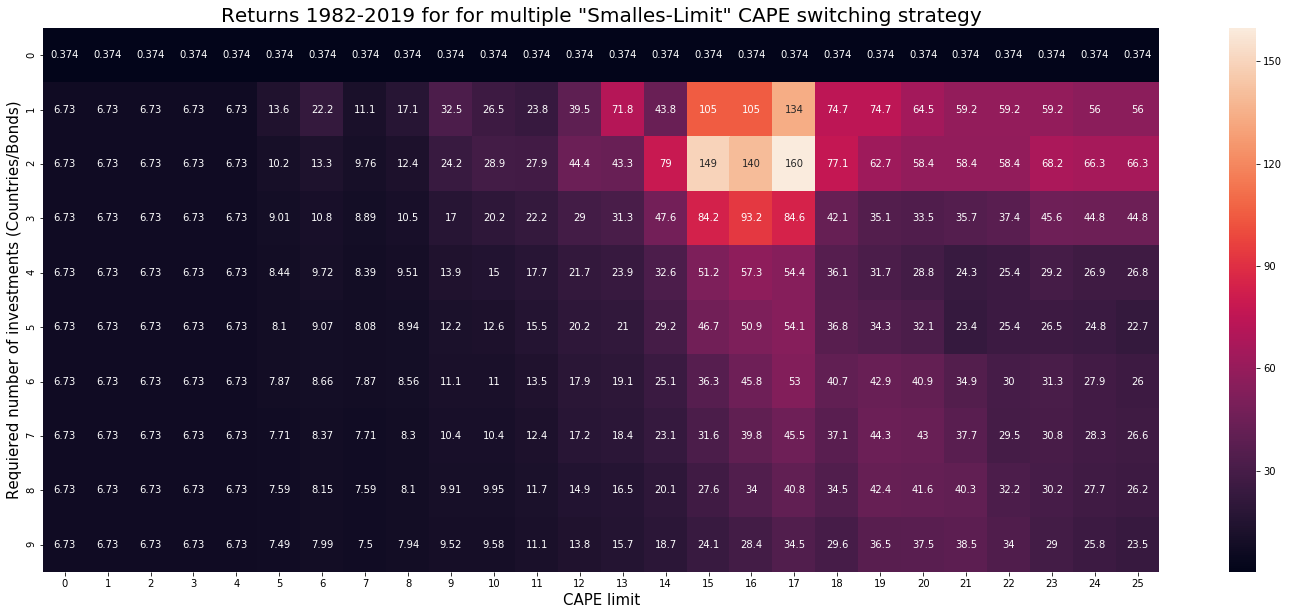

In [127]:
uniform_data = np.zeros((10, 26))
for x,y in returns.keys():
    uniform_data[x,y]=returns[(x,y)]
    
fig, ax = plt.subplots(figsize=(25,10)) 
ax.set_title('Returns 1982-2019 for for multiple "Smalles-Limit" CAPE switching strategy', size= 20)
ax = sns.heatmap(uniform_data, annot=True, ax=ax, fmt='.3g')
plt.xlabel('CAPE limit', size=15)
plt.ylabel('Requiered number of investments (Countries/Bonds)', size=15)
